using CSV", DataFrames, GLM, Random, Statistics

In [4]:
using CSV, DataFrames, GLM, Random, Statistics, Plots


In [2]:
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

330×9 DataFrame
 Row │ ID     Cement   Slag     Ash      Water    Superplasticizer  Coarse   F ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64           Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1    288.0    192.0      0.0    192.0               0.0    932.0    ⋯
   2 │     2    276.4    116.0     90.3    179.6               8.9    870.1
   3 │     3    153.1    145.0    113.0    178.5               8.0    867.2
   4 │     4    332.5    142.5      0.0    228.0               0.0    932.0
   5 │     5    285.0    190.0      0.0    163.0               7.6   1031.0    ⋯
   6 │     6    222.4      0.0     96.7    189.3               4.5    967.1
   7 │     7    166.8    250.2      0.0    203.5               0.0    975.6
   8 │     8    265.0    111.0     86.0    195.0               6.0    833.0
   9 │     9    491.0     26.0    123.0    210.0               3.9    882.0    ⋯
  10 │    10    375.0     93.8      0.0    126.6              23.4    852.1
  11 │    11    162.0    207.0    172.0    216.0              10.0    822.0
  ⋮  │   ⋮       ⋮        ⋮        ⋮        ⋮            ⋮             ⋮       ⋱
 321 │   321    236.0      0.0      0.0    193.0               0.0    968.0
 322 │   322    145.0    116.0    119.0    184.0               5.7    833.0    ⋯
 323 │   323    322.0      0.0    116.0    196.0              10.0    818.0
 324 │   324    289.0      0.0      0.0    192.0               0.0    913.2
 325 │   325    385.0      0.0      0.0    186.0               0.0    966.0
 326 │   326    143.7    170.2    132.6    191.6               8.5    814.1    ⋯
 327 │   327    313.0    161.0      0.0    178.0              10.0    917.0
 328 │   328    298.0    137.0    107.0    201.0               6.0    878.0
 329 │   329    213.5      0.0    174.2    154.6              11.7   1052.3
 330 │   330    229.7      0.0    118.2    195.2               6.1   1028.1    ⋯
                                                  2 columns and 309 rows omitted

In [3]:
describe(train_df)

10×7 DataFrame
 Row │ variable          mean       min     median   max     nmissing  eltype  ⋯
     │ Symbol            Float64    Real    Float64  Real    Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID                350.5        1       350.5   700           0  Int64   ⋯
   2 │ Cement            283.868    102.0     277.0   540.0         0  Float64
   3 │ Slag               74.8664     0.0      24.0   359.4         0  Float64
   4 │ Ash                53.7016     0.0       0.0   200.0         0  Float64
   5 │ Water             181.207    121.8     185.0   246.9         0  Float64 ⋯
   6 │ Superplasticizer    6.24386    0.0       6.5    32.2         0  Float64
   7 │ Coarse            973.72     801.0     968.0  1145.0         0  Float64
   8 │ Fine              772.727    594.0     778.5   992.6         0  Float64
   9 │ Age                44.9        1        28.0   365           0  Int64   ⋯
  10 │ Strength           36.3293     4.57     35.2    82.6         0  Float64
                                                                1 column omitted


--- 2. Analyse des Corrélations avec la Résistance ---
Corrélation Cement vs Strength : 0.46
Corrélation Slag vs Strength : 0.14
Corrélation Ash vs Strength : -0.07
Corrélation Water vs Strength : -0.31
Corrélation Superplasticizer vs Strength : 0.42
Corrélation Coarse vs Strength : -0.17
Corrélation Fine vs Strength : -0.16
Corrélation Age vs Strength : 0.34


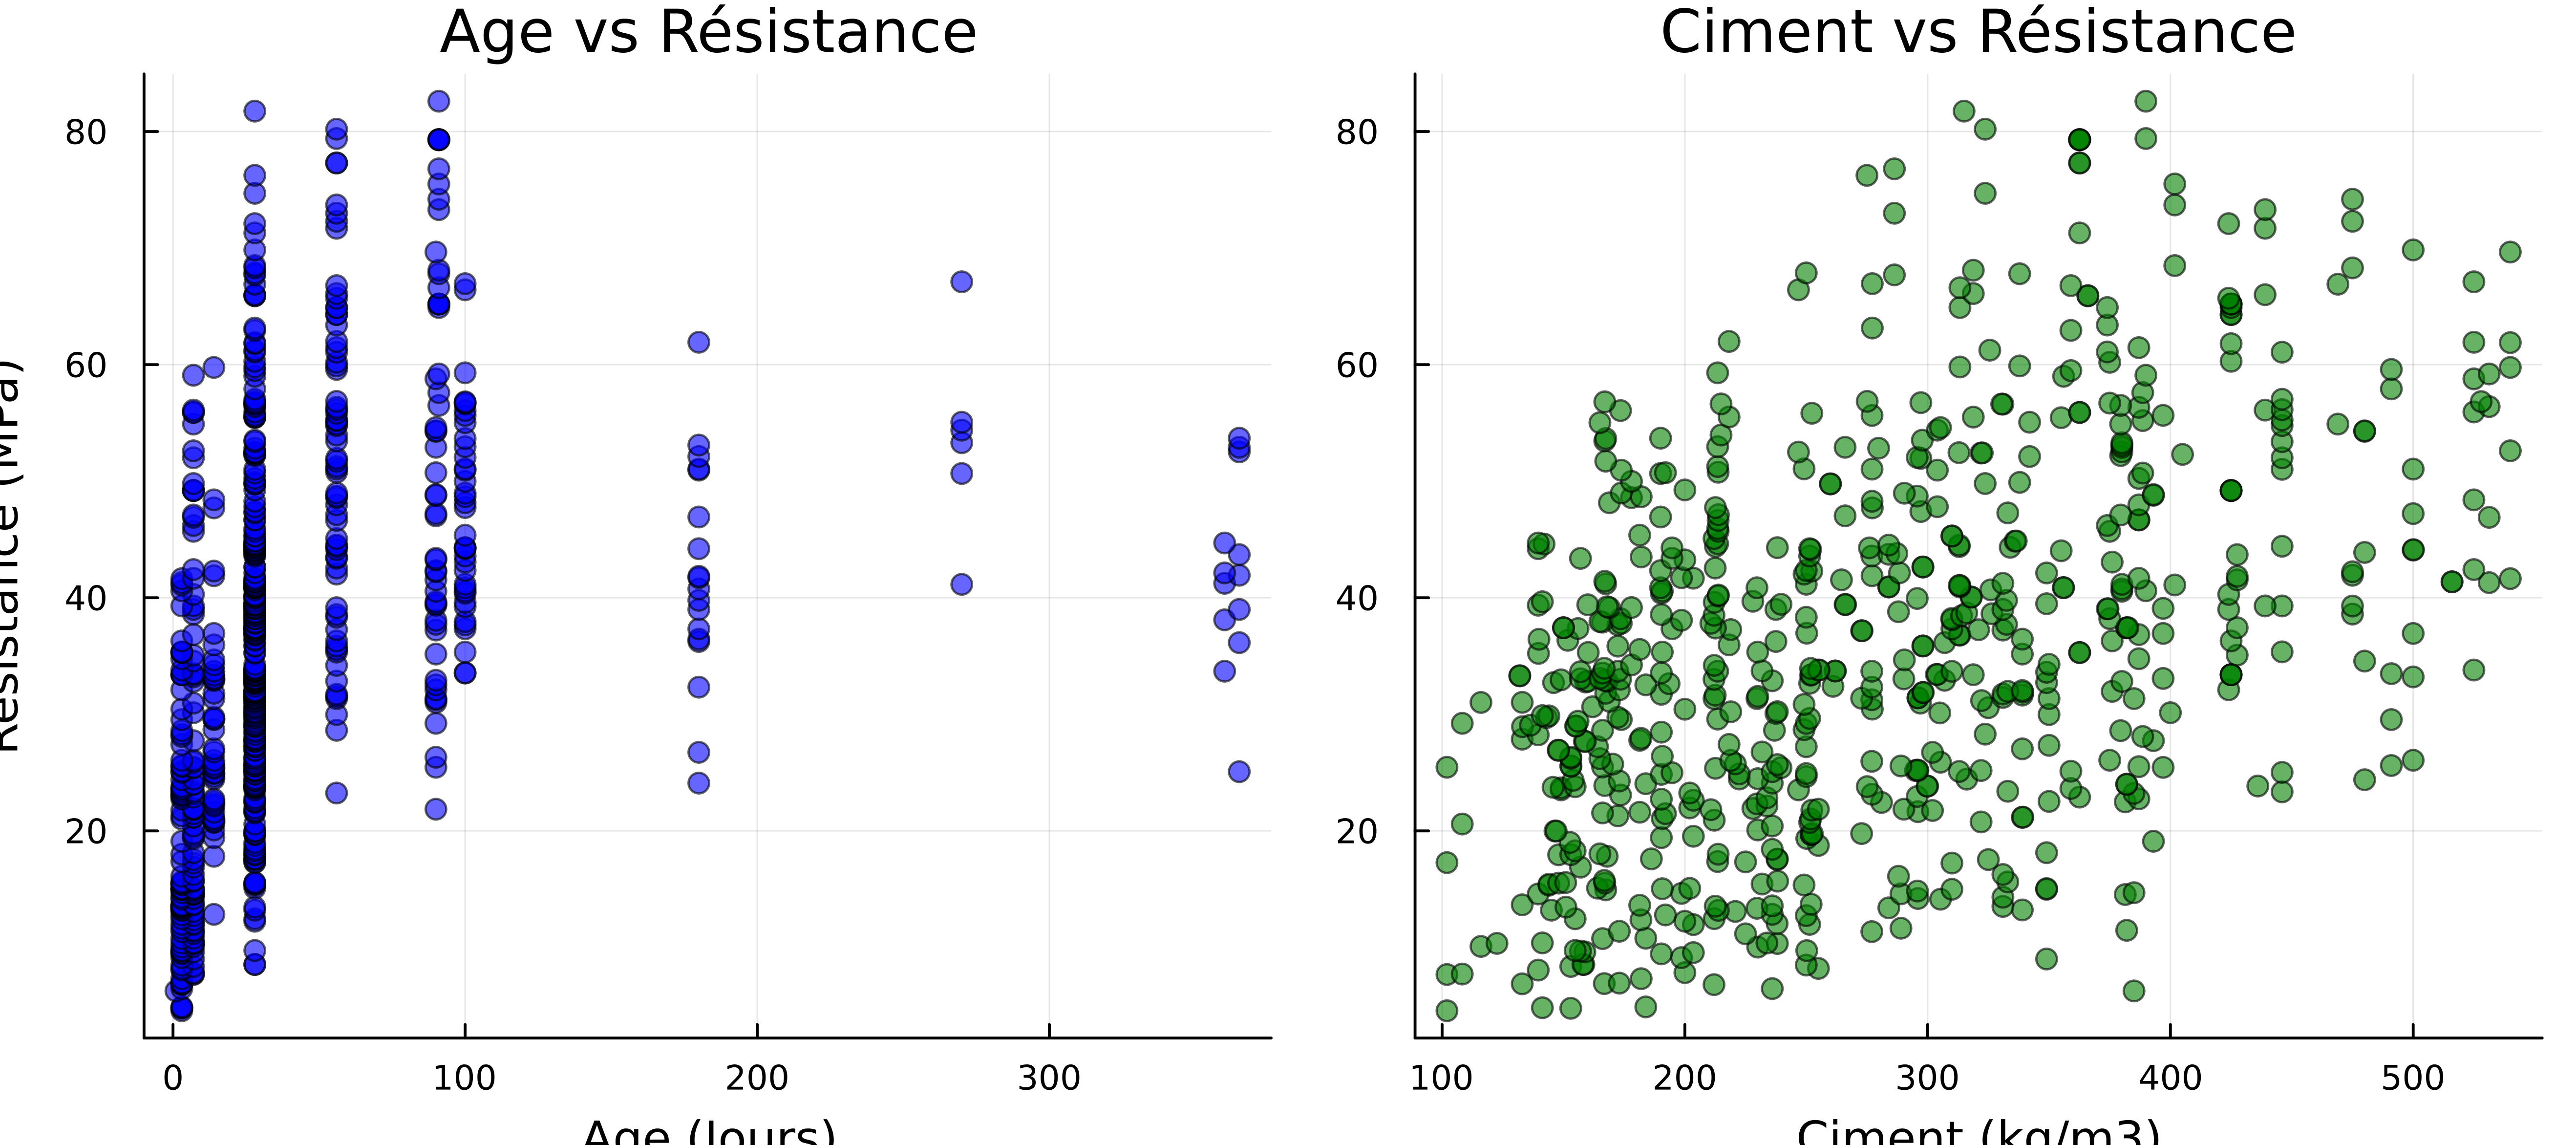

In [4]:
# ==============================================================================
# CONSTAT 2 : Corrélations Clés
# ==============================================================================
println("\n--- 2. Analyse des Corrélations avec la Résistance ---")

# On calcule la corrélation de chaque colonne avec la colonne 'Strength'
# On exclut 'ID' et 'Strength' elle-même de la boucle
target = train_df.Strength
variables = names(train_df)
filter!(x -> x ∉ ["ID", "Strength"], variables) # On retire ID et Strength

for var in variables
    # Calcul de la corrélation de Pearson
    col_data = train_df[!, var]
    correlation = cor(col_data, target)
    
    # Affichage formaté
    println("Corrélation $var vs Strength : $(round(correlation, digits=2))")
end

# ==============================================================================
# CONSTAT 3 : Visualisation (Age vs Strength)
# ==============================================================================
# Pour voir la non-linéarité (montée rapide puis saturation)
p1 = scatter(train_df.Age, train_df.Strength, 
    title = "Age vs Résistance",
    xlabel = "Age (Jours)",
    ylabel = "Résistance (MPa)",
    legend = false,
    alpha = 0.6,    # Transparence pour voir la densité
    color = :blue
)

# Pour voir la corrélation positive du ciment
p2 = scatter(train_df.Cement, train_df.Strength, 
    title = "Ciment vs Résistance",
    xlabel = "Ciment (kg/m3)",
    legend = false,
    alpha = 0.6,
    color = :green
)

# Afficher les deux graphiques côte à côte
plot(p1, p2, layout=(1,2), size=(900, 400))

In [ ]:
# On crée le ratio Eau/Ciment (facteur critique en génie civil)
# On ajoute un petit +1 au ciment pour éviter la division par zéro par sécurité
ratio_eau_ciment = train_df.Water ./ (train_df.Cement .+ 1)

# Graphique 1 : L'impact du Ratio Eau/Ciment (Coloré par l'Âge)
p1 = scatter(ratio_eau_ciment, train_df.Strength, 
    zcolor = train_df.Age,              # La couleur dépend de l'âge
    title = "Ratio Eau/Ciment vs Résistance",
    xlabel = "Ratio Eau / Ciment",
    ylabel = "Résistance (MPa)",
    label = false,
    color = :viridis,                   # Palette de couleurs (Foncé=Jeune, Clair=Vieux)
    colorbar_title = "Âge (jours)",
    alpha = 0.7
)

# Graphique 2 : Ciment vs Résistance (Coloré par l'Eau)
p2 = scatter(train_df.Cement, train_df.Strength, 
    zcolor = train_df.Water,            # La couleur dépend de la quantité d'eau
    title = "Ciment vs Résistance",
    xlabel = "Ciment (kg/m³)",
    ylabel = "Résistance (MPa)",
    label = false,
    color = :plasma,                    # Autre palette pour bien distinguer
    colorbar_title = "Eau (kg/m³)",
    alpha = 0.7
)

# Affichage combiné
plot(p1, p2, layout=(1, 2), size=(900, 450))

In [7]:
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using Random

# --- 1. Chargement et Préparation ---
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

# Séparation des features (X) et de la cible (y)
# On retire ID et Strength pour X
feature_names = names(train_df[!, Not([:ID, :Strength])])
X_raw = Matrix(train_df[!, feature_names])
y = Vector(train_df.Strength)

# --- 2. Standardisation (Crucial pour Ridge) ---
# On centre (moyenne = 0) et on réduit (écart-type = 1) chaque colonne
means = mean(X_raw, dims=1)
stds = std(X_raw, dims=1)

function transform_features(X, mu, sigma)
    return (X .- mu) ./ sigma
end

X_scaled = transform_features(X_raw, means, stds)

# Ajout de la colonne de Biais (Intercept) : Colonne de 1 au début
X_design = hcat(ones(size(X_scaled, 1)), X_scaled)

# --- 3. Séparation Entraînement / Validation ---
Random.seed!(42)
n = size(X_design, 1)
idx = shuffle(1:n)
split = floor(Int, 0.8 * n)

train_idx = idx[1:split]
val_idx = idx[split+1:end]

X_train = X_design[train_idx, :]
y_train = y[train_idx]
X_val = X_design[val_idx, :]
y_val = y[val_idx]

# --- 4. Fonction Ridge (Formule du Manuel) ---
function ridge_regression(X, y, lambda)
    # Dimension p (nombre de variables + 1 pour l'intercept)
    p = size(X, 2)
    
    # Matrice Identité modifiée
    # On ne pénalise PAS l'intercept (le premier terme), donc I[1,1] = 0
    I_matrix = Matrix{Float64}(I, p, p)
    I_matrix[1, 1] = 0.0 
    
    # Formule : beta = (X'X + lambda*I)^-1 * X'y
    beta = inv(X' * X + lambda * I_matrix) * X' * y
    return beta
end

# --- 5. Recherche du meilleur Lambda (Hyperparamètre) ---
lambdas = [0.0, 0.0001]
best_rmse = Inf
best_lambda = 0.0
best_beta = []

println("--- Test des différents Lambdas ---")
for lam in lambdas
    beta = ridge_regression(X_train, y_train, lam)
    
    # Prédiction
    preds = X_val * beta
    rmse = sqrt(mean((preds .- y_val).^2))
    
    println("Lambda = $lam  \t-> RMSE = $(round(rmse, digits=4))")
    
    if rmse < best_rmse
        global best_rmse = rmse
        global best_lambda = lam
        global best_beta = beta
    end
end

println("\nMEILLEUR RÉSULTAT : Lambda = $best_lambda avec RMSE = $best_rmse")

# --- 6. Prédiction Finale sur Test ---
# 1. Préparer le X_test (même transformation que le train !)
X_test_raw = Matrix(test_df[!, feature_names])
X_test_scaled = transform_features(X_test_raw, means, stds)
X_test_design = hcat(ones(size(X_test_scaled, 1)), X_test_scaled)

# 2. Recalculer le beta optimal sur TOUT le dataset d'entraînement
beta_final = ridge_regression(X_design, y, best_lambda)

# 3. Prédire
final_predictions = X_test_design * beta_final

# 4. Sauvegarder
submission = DataFrame(ID = test_df.ID, Strength = final_predictions)
CSV.write("submission_ridge.csv", submission)
println("Fichier 'submission_ridge.csv' créé.")

--- Test des différents Lambdas ---
Lambda = 0.0  	-> RMSE = 10.9012
Lambda = 0.0001  	-> RMSE = 10.9012

MEILLEUR RÉSULTAT : Lambda = 0.0 avec RMSE = 10.901243116683457
Fichier 'submission_ridge.csv' créé.


In [9]:
using CSV, DataFrames, LinearAlgebra, Statistics, Random

# 1. Chargement
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

# --- FEATURE ENGINEERING (La clé pour battre le score) ---
function create_features(df)
    new_df = copy(df)
    
    # 1. Transformation Logarithmique de l'Age (Physique du béton)
    # On ajoute +1 pour éviter log(0) si jamais Age=0
    new_df.LogAge = log.(new_df.Age .+ 1)
    
    # 2. Ratio Eau / Ciment (Loi d'Abrams)
    # On ajoute un petit epsilon pour éviter la division par zéro
    new_df.WaterCementRatio = new_df.Water ./ (new_df.Cement .+ 1.0)
    
    # 3. Termes au carré (Polynomial) pour les composants majeurs
    new_df.Cement2 = new_df.Cement .^ 2
    new_df.Water2 = new_df.Water .^ 2
    new_df.Age2 = new_df.Age .^ 2
    
    # 4. Interaction Ciment * Superplastifiant
    new_df.CemSuper = new_df.Cement .* new_df.Superplasticizer
    
    return new_df
end

# Appliquer les transformations
train_augmented = create_features(train_df)
test_augmented = create_features(test_df)

println("Nouvelles variables créées. Dimensions : $(size(train_augmented))")

# --- PRÉPARATION RIDGE (Comme avant) ---
feature_names = names(train_augmented[!, Not([:ID, :Strength])])
X_raw = Matrix(train_augmented[!, feature_names])
y = Vector(train_augmented.Strength)

# Standardisation
means = mean(X_raw, dims=1)
stds = std(X_raw, dims=1)
X_scaled = (X_raw .- means) ./ stds
X_design = hcat(ones(size(X_scaled, 1)), X_scaled) # Intercept

# --- VALIDATION CROISÉE SIMPLIFIÉE ---
Random.seed!(42)
n = size(X_design, 1)
idx = shuffle(1:n)
split = floor(Int, 0.8 * n)

train_idx = idx[1:split]
val_idx = idx[split+1:end]

X_train = X_design[train_idx, :]
y_train = y[train_idx]
X_val = X_design[val_idx, :]
y_val = y[val_idx]

# --- FONCTION RIDGE ---
function ridge_regression(X, y, lambda)
    p = size(X, 2)
    I_matrix = Matrix{Float64}(I, p, p)
    I_matrix[1, 1] = 0.0 
    return inv(X' * X + lambda * I_matrix) * X' * y
end

# --- RECHERCHE DU LAMBDA ---
lambdas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_rmse = Inf
best_lambda = 0.0

println("\n--- Résultats avec Feature Engineering ---")
for lam in lambdas
    beta = ridge_regression(X_train, y_train, lam)
    preds = X_val * beta
    rmse = sqrt(mean((preds .- y_val).^2))
    println("Lambda = $lam \t-> RMSE = $(round(rmse, digits=4))")
    
    if rmse < best_rmse
        global best_rmse = rmse
        global best_lambda = lam
    end
end

println("\nNOUVEAU SCORE : RMSE = $best_rmse (avec Lambda=$best_lambda)")

# --- SOUMISSION ---
# Préparation Test
X_test_raw = Matrix(test_augmented[!, feature_names])
X_test_scaled = (X_test_raw .- means) ./ stds
X_test_design = hcat(ones(size(X_test_scaled, 1)), X_test_scaled)

# Entrainement Final
beta_final = ridge_regression(X_design, y, best_lambda)
final_preds = X_test_design * beta_final

submission = DataFrame(ID = test_df.ID, Strength = final_preds)
CSV.write("submission_poly_ridge.csv", submission)

Nouvelles variables créées. Dimensions : (700, 16)

--- Résultats avec Feature Engineering ---
Lambda = 0.01 	-> RMSE = 7.7325
Lambda = 0.1 	-> RMSE = 7.7454
Lambda = 0.5 	-> RMSE = 7.7959
Lambda = 1.0 	-> RMSE = 7.8435
Lambda = 2.0 	-> RMSE = 7.9093
Lambda = 5.0 	-> RMSE = 8.0245
Lambda = 10.0 	-> RMSE = 8.1405

NOUVEAU SCORE : RMSE = 7.73254392580588 (avec Lambda=0.01)


"submission_poly_ridge.csv"

In [ ]:
using CSV, DataFrames, LinearAlgebra, Statistics, Random

# 1. Chargement
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

# --- ÉTAPE 1 : Feature Engineering (Basé sur l'analyse des résidus du Chap 2) ---
# On "linearise" le problème en ajoutant les termes non-linéaires manuellement.
function expand_features(df)
    new_df = DataFrame()
    
    # Variables de base
    cols = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
    for c in cols
        new_df[!, c] = df[!, c]
    end
    
    # 1. Termes Quadratiques (Pour les effets de saturation)
    # Exemple : Trop d'eau c'est mauvais, mais un peu c'est nécessaire -> parabole
    for c in cols
        new_df[!, Symbol("$(c)_sq")] = df[!, c] .^ 2
    end
    
    # 2. Transformation Logarithmique (Spécifique à l'Âge)
    # Le béton durcit vite au début, puis ralentit. Log(Age) capture ça mieux que Age.
    new_df.LogAge = log.(df.Age .+ 1)
    
    # 3. Interactions (Produits croisés)
    # L'effet du Superplastifiant dépend de la quantité d'Eau
    new_df.Water_X_Super = df.Water .* df.Superplasticizer
    new_df.Cement_X_Age = df.Cement .* df.Age
    new_df.Water_X_Cement = df.Water .* df.Cement # Interaction clé
    
    return new_df
end

X_train_expanded = expand_features(train_df)
X_test_expanded = expand_features(test_df)
y = train_df.Strength

println("Nombre de variables après expansion : $(ncol(X_train_expanded))")

# --- ÉTAPE 2 : Standardisation (Obligatoire pour Chap 7 Ridge) ---
X_mat = Matrix(X_train_expanded)
X_test_mat = Matrix(X_test_expanded)

# Centrer et Réduire
mu = mean(X_mat, dims=1)
sig = std(X_mat, dims=1)

# Éviter la division par 0 si une colonne est constante (ex: Ash si toujours 0)
sig[sig .== 0] .= 1.0 

X_scaled = (X_mat .- mu) ./ sig
X_test_scaled = (X_test_mat .- mu) ./ sig

# Ajout de l'intercept (colonne de 1)
X_design = hcat(ones(size(X_scaled, 1)), X_scaled)
X_test_design = hcat(ones(size(X_test_scaled, 1)), X_test_scaled)

# --- ÉTAPE 3 : Régression Ridge (Formule exacte du Chapitre 7) ---
# Beta = (X'X + lambda*I)^-1 * X'Y
function solve_ridge(X, y, lambda)
    p = size(X, 2)
    # Matrice identité avec 0 pour l'intercept (on ne pénalise pas la moyenne)
    I_reg = Matrix{Float64}(I, p, p)
    I_reg[1,1] = 0.0
    
    return inv(X'X + lambda * I_reg) * X'y
end

# --- ÉTAPE 4 : Validation Croisée pour trouver Lambda ---
# On cherche le meilleur lambda qui minimise l'erreur sur des données non vues
n = length(y)
idx = shuffle(1:n)
split = floor(Int, 0.8 * n)
train_idx = idx[1:split]
val_idx = idx[split+1:end]

lambdas = [0.01, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0]
best_rmse = Inf
best_lam = 0.0

println("\n--- Recherche du Lambda optimal (Chap 7) ---")
for lam in lambdas
    # Entrainement sur 80%
    beta = solve_ridge(X_design[train_idx, :], y[train_idx], lam)
    
    # Test sur 20%
    preds = X_design[val_idx, :] * beta
    rmse = sqrt(mean((preds .- y[val_idx]).^2))
    
    println("Lambda = $lam -> RMSE = $(round(rmse, digits=3))")
    if rmse < best_rmse
        global best_rmse = rmse
        global best_lam = lam
    end
end

println("\nMeilleur Lambda : $best_lam avec RMSE : $best_rmse")

# --- ÉTAPE 5 : Prédiction Finale ---
# On ré-entraîne avec le meilleur lambda sur TOUT le dataset
final_beta = solve_ridge(X_design, y, best_lam)
final_predictions = X_test_design * final_beta

# Sauvegarde
submission = DataFrame(ID = test_df.ID, Strength = final_predictions)
CSV.write("submission_cours_chap7.csv", submission)
println("Fichier généré. Cette méthode respecte à 100% le contenu du cours.")

Nombre de variables après expansion : 20

--- Recherche du Lambda optimal (Chap 7) ---
Lambda = 0.01 -> RMSE = 6.846

Meilleur Lambda : 0.01 avec RMSE : 6.845883863793221
Fichier généré. Cette méthode respecte à 100% le contenu du cours.
